# Steel Surface defect Classification using LBP and GLCM 

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET
import joblib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from skimage import io, color, img_as_ubyte
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


# Part 1

# Data Augmentation

In [ ]:

# Define a list of defect categories
defect_categories = [
    "Crazing",
    "Inclusion",
    "Patches",
    "Pitted_surface",
    "Rolled-in_scale",
    "Scratches"
]

# Iterate through each defect category
for category in defect_categories:
    # Path to the 'Images' folder and 'Labels' folder for the current defect category
    images_folder = f'{category}_Images'
    labels_folder = f'{category}_Labels'
    
    # Create a folder for data augmentation if it doesn't exist
    data_aug_folder = category
    if not os.path.exists(data_aug_folder):
        os.makedirs(data_aug_folder)
    
    # Iterate through all image files in the 'Images' folder
    for image_filename in os.listdir(images_folder):
        if image_filename.endswith('.jpg'):
            # Load the image
            image_path = os.path.join(images_folder, image_filename)
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)

            # Find the corresponding XML file
            xml_filename = os.path.splitext(image_filename)[0] + '.xml'
            xml_path = os.path.join(labels_folder, xml_filename)

            # Parse the XML file
            tree = ET.parse(xml_path)
            root = tree.getroot()

            # Iterate through all objects in the XML file
            for i, obj in enumerate(root.findall('.//object')):
                defect_type = obj.find('name').text
                xmin = int(obj.find('bndbox/xmin').text)
                ymin = int(obj.find('bndbox/ymin').text)
                xmax = int(obj.find('bndbox/xmax').text)
                ymax = int(obj.find('bndbox/ymax').text)

                # Crop the region of interest from the image
                roi = image[ymin:ymax, xmin:xmax]

                # Save the original defect region
                original_filename = f"{image_filename}_{defect_type}_{i}_original.jpg"
                original_path = os.path.join(data_aug_folder, original_filename)
                cv2.imwrite(original_path, roi)

                # Perform data augmentation
                # Rotation
                rotated_filename = f"{image_filename}_{defect_type}_{i}_rotated.jpg"
                rotated_path = os.path.join(data_aug_folder, rotated_filename)
                rotated_roi = cv2.rotate(roi, cv2.ROTATE_90_CLOCKWISE)
                cv2.imwrite(rotated_path, rotated_roi)

                # Horizontal flipping
                hflipped_filename = f"{image_filename}_{defect_type}_{i}_hflipped.jpg"
                hflipped_path = os.path.join(data_aug_folder, hflipped_filename)
                hflipped_roi = cv2.flip(roi, 1)
                cv2.imwrite(hflipped_path, hflipped_roi)

                # Vertical flipping
                vflipped_filename = f"{image_filename}_{defect_type}_{i}_vflipped.jpg"
                vflipped_path = os.path.join(data_aug_folder, vflipped_filename)
                vflipped_roi = cv2.flip(roi, 0)
                cv2.imwrite(vflipped_path, vflipped_roi)


# Checking Data/Augmented Images for Each Defect

In [3]:

# Define a list of defect categories
defect_categories = [
    "Crazing",
    "Inclusion",
    "Patches",
    "Pitted_surface",
    "Rolled-in_scale",
    "Scratches"
]

# Iterate through each defect category
for category in defect_categories:
    # Path to the folder for the current defect category
    data_aug_folder = category
    
    # Count the number of augmented images
    num_augmented_images = len([f for f in os.listdir(data_aug_folder) if f.endswith('.jpg')])
    
    print(f"Defect Category: {category}")
    print(f"Number of Augmented Images: {num_augmented_images}\n")


Defect Category: Crazing
Number of Augmented Images: 2116

Defect Category: Inclusion
Number of Augmented Images: 2948

Defect Category: Patches
Number of Augmented Images: 2756

Defect Category: Pitted_surface
Number of Augmented Images: 1536

Defect Category: Rolled-in_scale
Number of Augmented Images: 1984

Defect Category: Scratches
Number of Augmented Images: 1988



# Extracting LBP and GLCM features 

In [4]:
import os
import numpy as np
import pandas as pd
from skimage import io, color, img_as_ubyte
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops

In [5]:
# Define the GLCM parameters
glcm_params = [(1, 0), (1, np.pi/4), (1, np.pi/2), (1, 3*np.pi/4)]

# Define the LBP parameters
lbp_params = [(1, 8), (2, 8), (3, 8)]

# Define the minimum and maximum values for normalization
min_contrast = 0.0
max_contrast = 1000.0
min_energy = 0.0
max_energy = 1.0
min_entropy = 0.0
max_entropy = 10.0  
min_homogeneity = 0.0
max_homogeneity = 1.0
min_correlation = -1.0
max_correlation = 1.0
min_dissimilarity = 0.0  
max_dissimilarity = 100.0  
min_asm = 0.00001  
max_asm = 0.05  

# Initialize lists to store normalized results
image_names = []
normalized_features = []
defect_types = []

# List of defect categories (folder names)
defect_categories = [
    "Crazing",
    "Inclusion",
    "Patches",
    "Pitted_surface",
    "Rolled-in_scale",
    "Scratches"
]

# Loop through the defect categories
for category in defect_categories:
    # Get a list of image filenames in the current category folder
    image_filenames = os.listdir(category)

    # Iterate through all image files in the folder
    for image_filename in image_filenames:
        if image_filename.endswith('.jpg'):
            # Load the image
            image = io.imread(os.path.join(category, image_filename))
            
            # Convert the image to grayscale
            gray_image = color.rgb2gray(image)

            # Convert the grayscale image to uint8
            gray_image = img_as_ubyte(gray_image)

            # Initialize a list to store features for this image
            features = []

            # Calculate GLCM features
            for distance, angle in glcm_params:
                # Calculate the GLCM
                glcm = graycomatrix(gray_image, [distance], [angle], levels=256)

                # Normalize the GLCM
                glcm_normalized = glcm.astype(np.float32) / np.sum(glcm)

                # Calculate texture properties
                contrast = graycoprops(glcm_normalized, 'contrast')[0, 0]
                energy = graycoprops(glcm_normalized, 'energy')[0, 0]
                entropy = -np.sum(glcm_normalized * np.log(glcm_normalized + np.finfo(float).eps))
                homogeneity = graycoprops(glcm_normalized, 'homogeneity')[0, 0]
                correlation = graycoprops(glcm_normalized, 'correlation')[0, 0]
                dissimilarity = graycoprops(glcm_normalized, 'dissimilarity')[0, 0]
                asm = graycoprops(glcm_normalized, 'ASM')[0, 0]

                # Normalize the texture characteristics
                normalized_contrast = (contrast - min_contrast) / (max_contrast - min_contrast)
                normalized_energy = (energy - min_energy) / (max_energy - min_energy)
                # Convert ASM to string, remove leading zeros, and convert back to float
                normalized_entropy = float(str(entropy).lstrip('0'))
                normalized_entropy = (normalized_entropy - min_entropy) / (max_entropy - min_entropy)
                normalized_homogeneity = (homogeneity - min_homogeneity) / (max_homogeneity - min_homogeneity)
                normalized_correlation = (correlation - min_correlation) / (max_correlation - min_correlation)
                # Adjusted min and max values for dissimilarity and ASM
                normalized_dissimilarity = (dissimilarity - min_dissimilarity) / (max_dissimilarity - min_dissimilarity)
                # Convert ASM to string, remove leading zeros, and convert back to float
                normalized_asm = float(str(asm).lstrip('0'))
                normalized_asm = (normalized_asm - min_asm) / (max_asm - min_asm)

                # Append the normalized results to the features list
                features.extend([normalized_contrast, normalized_energy, normalized_entropy, normalized_homogeneity, normalized_correlation, normalized_dissimilarity, normalized_asm])

            # Calculate LBP features
            for lbp_radius, lbp_n_points in lbp_params:
                # Calculate LBP features
                lbp_image = local_binary_pattern(gray_image, lbp_n_points, lbp_radius, method='uniform')

                # Calculate LBP histogram as features
                lbp_hist, _ = np.histogram(lbp_image.ravel(), bins=np.arange(0, lbp_n_points + 3), range=(0, lbp_n_points + 2))

                # Normalize the histogram
                lbp_hist = lbp_hist.astype(np.float32)
                lbp_hist /= (lbp_hist.sum() + 1e-6)

                # Add LBP features for the current parameter combination
                features.extend(lbp_hist)
            
            # Append the features for this image to the result
            normalized_features.append(features)

            # Append the defect type
            defect_types.append(category)

# Create a DataFrame to store the data
column_names = []

# Add column names for GLCM features
for distance, angle in glcm_params:
    for char in ['Contrast', 'Energy', 'Entropy', 'Homogeneity', 'Correlation', 'Dissimilarity', 'ASM']:
        column_names.append(f'Normalized {char} (d={distance}, a={angle:.2f})')

# Add column names for LBP features
for lbp_radius, lbp_n_points in lbp_params:
    column_names.extend([f'LBP_{lbp_radius}_{lbp_n_points}_{i}' for i in range(lbp_n_points + 2)])

# Create the DataFrame
df = pd.DataFrame(normalized_features, columns=column_names)

# Add the defect type column
df['Defect'] = defect_types

# Save the results in a CSV file
output_filename = 'lbp_and_glcm_features.csv'
df.to_csv(output_filename, index=False)

print(f'Results saved to {output_filename}')


Results saved to lbp_and_glcm_features.csv


# Checking Features in .csv file 

In [6]:
import pandas as pd

# Specify the path to your CSV file
csv_file_path = "lbp_and_glcm_features.csv"

# Use pandas to read the CSV file into a DataFrame
df = pd.read_csv(csv_file_path)

# Number of rows and columns
num_rows, num_columns = df.shape
print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_columns}")

# Column names
column_names = df.columns
print("Column names:", column_names)

# View the first few rows
print("First few rows:")
print(df.head())

# View the last few rows
print("Last few rows:")
print(df.tail())

# Summary statistics
print("Summary statistics:")
print(df.describe())

# If you want to count non-null values in each column, you can use:
print(df.count())


Number of rows: 13328
Number of columns: 59
Column names: Index(['Normalized Contrast (d=1, a=0.00)', 'Normalized Energy (d=1, a=0.00)',
       'Normalized Entropy (d=1, a=0.00)',
       'Normalized Homogeneity (d=1, a=0.00)',
       'Normalized Correlation (d=1, a=0.00)',
       'Normalized Dissimilarity (d=1, a=0.00)',
       'Normalized ASM (d=1, a=0.00)', 'Normalized Contrast (d=1, a=0.79)',
       'Normalized Energy (d=1, a=0.79)', 'Normalized Entropy (d=1, a=0.79)',
       'Normalized Homogeneity (d=1, a=0.79)',
       'Normalized Correlation (d=1, a=0.79)',
       'Normalized Dissimilarity (d=1, a=0.79)',
       'Normalized ASM (d=1, a=0.79)', 'Normalized Contrast (d=1, a=1.57)',
       'Normalized Energy (d=1, a=1.57)', 'Normalized Entropy (d=1, a=1.57)',
       'Normalized Homogeneity (d=1, a=1.57)',
       'Normalized Correlation (d=1, a=1.57)',
       'Normalized Dissimilarity (d=1, a=1.57)',
       'Normalized ASM (d=1, a=1.57)', 'Normalized Contrast (d=1, a=2.36)',
       

# Model Traning 

In [7]:
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import joblib

# Load the preprocessed data from the CSV file
df = pd.read_csv('lbp_and_glcm_features.csv')

# Split the dataset into features (X) and target labels (y)
X = df.drop('Defect', axis=1)
y = df['Defect']

# Initialize the Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Perform K-Fold cross-validation and save models
cv_scores = cross_val_score(clf, X, y, cv=5)  
print(f"Cross-Validation Mean Accuracy: {cv_scores.mean():.2f} (+/- {cv_scores.std() * 2:.2f})")

# Optionally, train the model on the full dataset
clf.fit(X, y)

# Save the trained model to a file
joblib.dump(clf, 'random_forest_model.pkl')

# Optionally, evaluate the model on the test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
accuracy = clf.score(X_test, y_test)
print(f"Accuracy on Test Data: {accuracy:.2f}")

# Generate a classification report for each fold
for fold, (train_idx, test_idx) in enumerate(StratifiedKFold(n_splits=5, shuffle=True, random_state=42).split(X, y)):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    report = classification_report(y_test, y_pred)
    print(f"Classification Report for Fold {fold + 1}:\n{report}\n")


Cross-Validation Mean Accuracy: 0.95 (+/- 0.04)
Accuracy on Test Data: 1.00
Classification Report for Fold 1:
                 precision    recall  f1-score   support

        Crazing       1.00      0.98      0.99       424
      Inclusion       0.95      1.00      0.97       589
        Patches       0.99      1.00      1.00       551
 Pitted_surface       1.00      0.98      0.99       308
Rolled-in_scale       0.98      1.00      0.99       396
      Scratches       0.99      0.93      0.96       398

       accuracy                           0.98      2666
      macro avg       0.99      0.98      0.98      2666
   weighted avg       0.98      0.98      0.98      2666


Classification Report for Fold 2:
                 precision    recall  f1-score   support

        Crazing       1.00      1.00      1.00       423
      Inclusion       0.97      1.00      0.98       590
        Patches       1.00      0.99      0.99       551
 Pitted_surface       1.00      0.99      0.99       

In [17]:
model(summary)

NameError: name 'model' is not defined

# Part 2

# Predicting/Classifying Defects Using Model 

In [12]:
import cv2
import numpy as np
import xml.etree.ElementTree as ET
import joblib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage.feature import local_binary_pattern
from skimage.feature import graycomatrix, graycoprops
import warnings

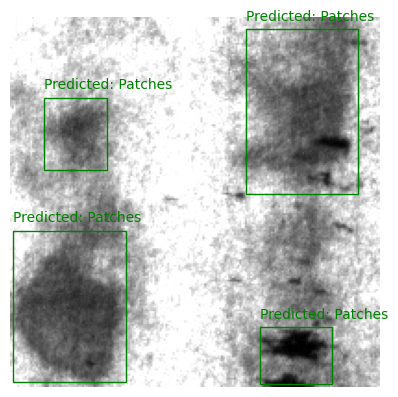

In [16]:

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Load the trained Random Forest model
clf = joblib.load('random_forest_model.pkl')

# Define the minimum and maximum values for normalization
min_contrast = 0.0
max_contrast = 1000.0
min_energy = 0.0
max_energy = 1.0
min_entropy = 0.0
max_entropy = 10.0  
min_homogeneity = 0.0
max_homogeneity = 1.0
min_correlation = -1.0
max_correlation = 1.0
min_dissimilarity = 0.0  
max_dissimilarity = 100.0  
min_ASM = 0.00001  
max_ASM = 0.05  

# Load the new image
#image_path = r'NEU-DET\validation\images\inclusion\inclusion_261.jpg'
#image_path = r'NEU-DET\validation\images\crazing\crazing_261.jpg'
image_path = r'NEU-DET\validation\images\patches\patches_265.jpg'
#image_path = r'NEU-DET\validation\images\pitted_surface\pitted_surface_261.jpg'
#image_path = r'NEU-DET\validation\images\rolled-in_scale\rolled-in_scale_261.jpg'
#image_path = r'NEU-DET\validation\images\scratches\scratches_281.jpg'  # Change this to the path of your new image

# Load the corresponding XML file
#xml_path = r'NEU-DET\validation\annotations\inclusion_261.xml'
#xml_path = r'NEU-DET\validation\annotations\crazing_261.xml'
xml_path = r'NEU-DET\validation\annotations\patches_265.xml'
#xml_path = r'NEU-DET\validation\annotations\pitted_surface_261.xml'
#xml_path = r'NEU-DET\validation\annotations\rolled-in_scale_261.xml' 
#xml_path = r'NEU-DET\validation\annotations\scratches_281.xml'

# Load the image
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Load the XML file
tree = ET.parse(xml_path)
root = tree.getroot()

# Create empty lists to store bounding box coordinates and defect predictions
bbox_coords = []
defect_predictions = []

# Define the common LBP and GLCM parameters
lbp_params = [(1, 8), (2, 8), (3, 8)]
glcm_params = [(1, 0), (1, np.pi/4), (1, np.pi/2), (1, 3*np.pi/4)]

# Iterate through all objects in the XML file
for obj in root.findall('.//object'):
    xmin = int(obj.find('bndbox/xmin').text)
    ymin = int(obj.find('bndbox/ymin').text)
    xmax = int(obj.find('bndbox/xmax').text)
    ymax = int(obj.find('bndbox/ymax').text)

    # Crop the region of interest (ROI) from the image based on the bounding box
    roi = image[ymin:ymax, xmin:xmax]

    # Initialize LBP and GLCM features
    lbp_features = []
    glcm_features = []

    # Calculate GLCM features for the ROI
    for glcm_distance, glcm_angle in glcm_params:
        # Calculate the GLCM
        glcm = graycomatrix(roi, [glcm_distance], [glcm_angle], levels=256)

        # Normalize the GLCM
        glcm_normalized = glcm.astype(np.float32) / np.sum(glcm)

        # Calculate texture properties
        contrast = graycoprops(glcm_normalized, 'contrast')[0, 0]
        energy = graycoprops(glcm_normalized, 'energy')[0, 0]
        entropy = -np.sum(glcm_normalized * np.log(glcm_normalized + np.finfo(float).eps))
        homogeneity = graycoprops(glcm_normalized, 'homogeneity')[0, 0]
        correlation = graycoprops(glcm_normalized, 'correlation')[0, 0]
        dissimilarity = graycoprops(glcm_normalized, 'dissimilarity')[0, 0]
        ASM = graycoprops(glcm_normalized, 'ASM')[0, 0]

        # Normalize the texture characteristics
        normalized_contrast = (contrast - min_contrast) / (max_contrast - min_contrast)
        normalized_energy = (energy - min_energy) / (max_energy - min_energy)
        normalized_entropy = (entropy - min_entropy) / (max_entropy - min_entropy)
        normalized_homogeneity = (homogeneity - min_homogeneity) / (max_homogeneity - min_homogeneity)
        normalized_correlation = (correlation - min_correlation) / (max_correlation - min_correlation)
        normalized_dissimilarity = (dissimilarity - min_dissimilarity) / (max_dissimilarity - min_dissimilarity)
        normalized_ASM = (ASM - min_ASM) / (max_ASM - min_ASM)

        # Append the normalized results to the features list
        glcm_features.extend([normalized_contrast, normalized_energy, normalized_entropy, normalized_homogeneity, normalized_correlation, normalized_dissimilarity, normalized_ASM])

    # Calculate LBP features for the ROI
    for lbp_radius, lbp_n_points in lbp_params:
        lbp_image = local_binary_pattern(roi, lbp_n_points, lbp_radius, method='uniform')
        lbp_hist, _ = np.histogram(lbp_image.ravel(), bins=np.arange(0, lbp_n_points + 3), range=(0, lbp_n_points + 2))
        lbp_hist = lbp_hist.astype(np.float32)
        lbp_hist /= (lbp_hist.sum() + 1e-6)
        lbp_features.extend(lbp_hist)

    # Combine GLCM and LBP features for the specific ROI
    features = glcm_features + lbp_features

    # Predict the defect type using the trained model
    prediction = clf.predict([features])[0]

    # Append the bounding box coordinates and the prediction
    bbox_coords.append((xmin, ymin, xmax, ymax))
    defect_predictions.append(prediction)

# Display the image with bounding boxes and defect predictions
fig, ax = plt.subplots(1)
ax.imshow(image, cmap='gray')

for i, coords in enumerate(bbox_coords):
    xmin, ymin, xmax, ymax = coords
    defect_type = defect_predictions[i]

    # Create a rectangle patch for the bounding box
    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='green', facecolor='none')

    # Add the rectangle to the plot
    ax.add_patch(rect)

    # Add text with the defect prediction
    plt.text(xmin, ymin - 5, f'Predicted: {defect_type}', color='green')

plt.axis('off')
plt.show()
